In [2]:
%pip install sklearn 
import seaborn as sns
import numpy as np
from seafreeze import seafreeze as sf
import os as os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


Note: you may need to restart the kernel to use updated packages.


The main challenges with this dataset are probably high dimensionality, high variance, and the sheer amount of data. A non-linear methods dimensionality reduction method might perform better once I figure out how to implement that without the kernel crashing.

/opt/anaconda3/envs/mlgeo-dataset/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


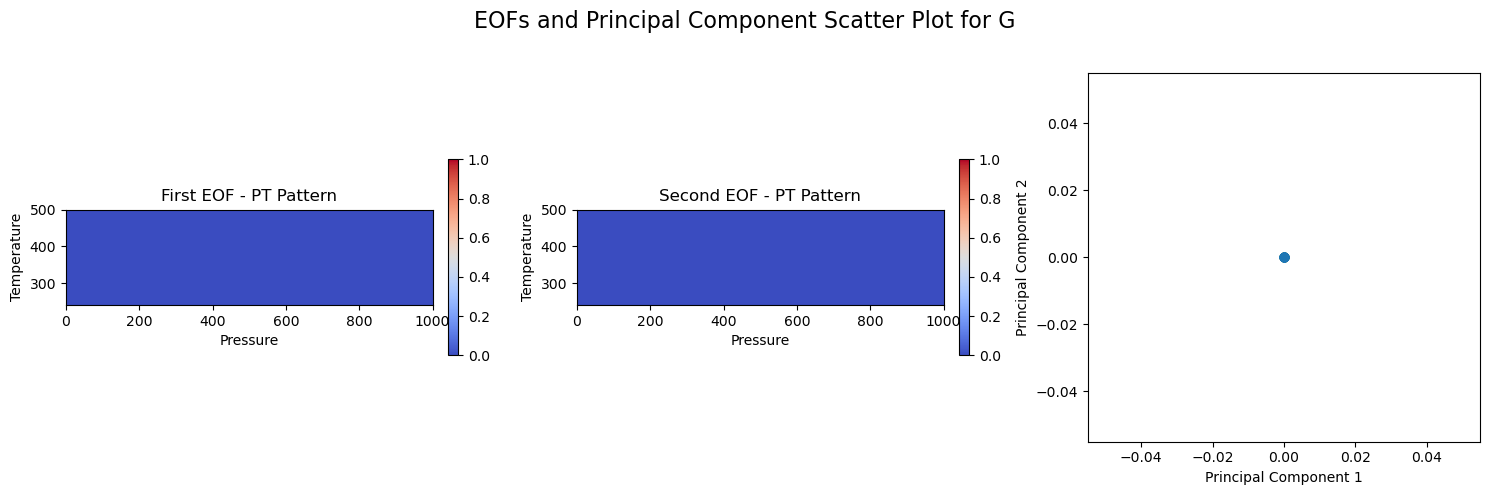

Explained Variance Ratios: [nan nan]


/opt/anaconda3/envs/mlgeo-dataset/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


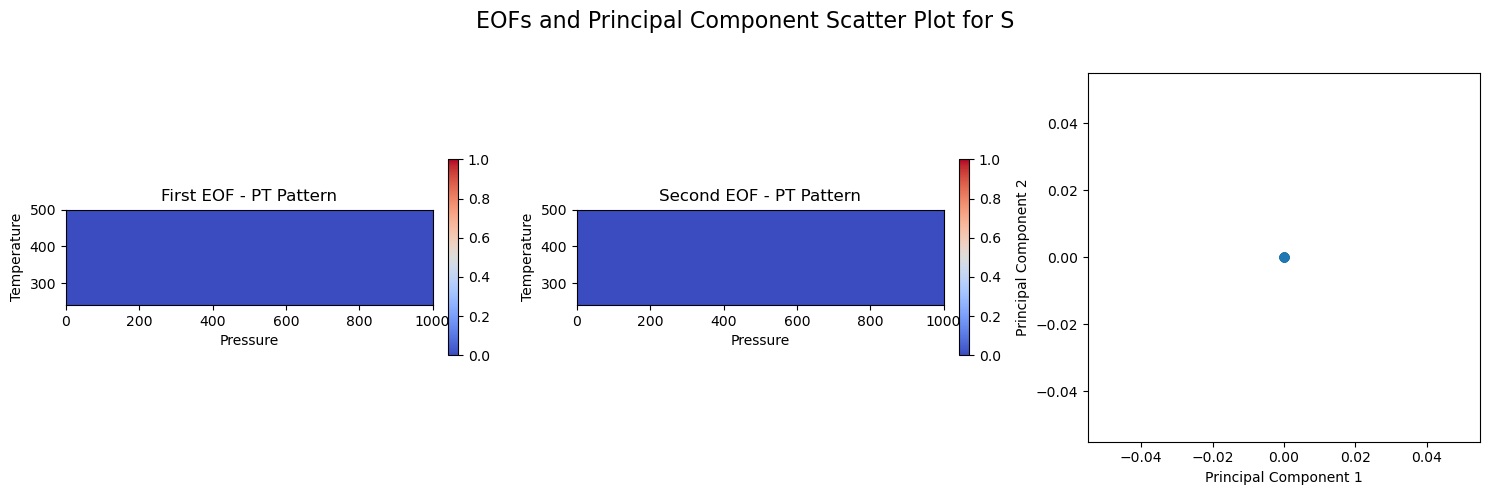

Explained Variance Ratios: [nan nan]


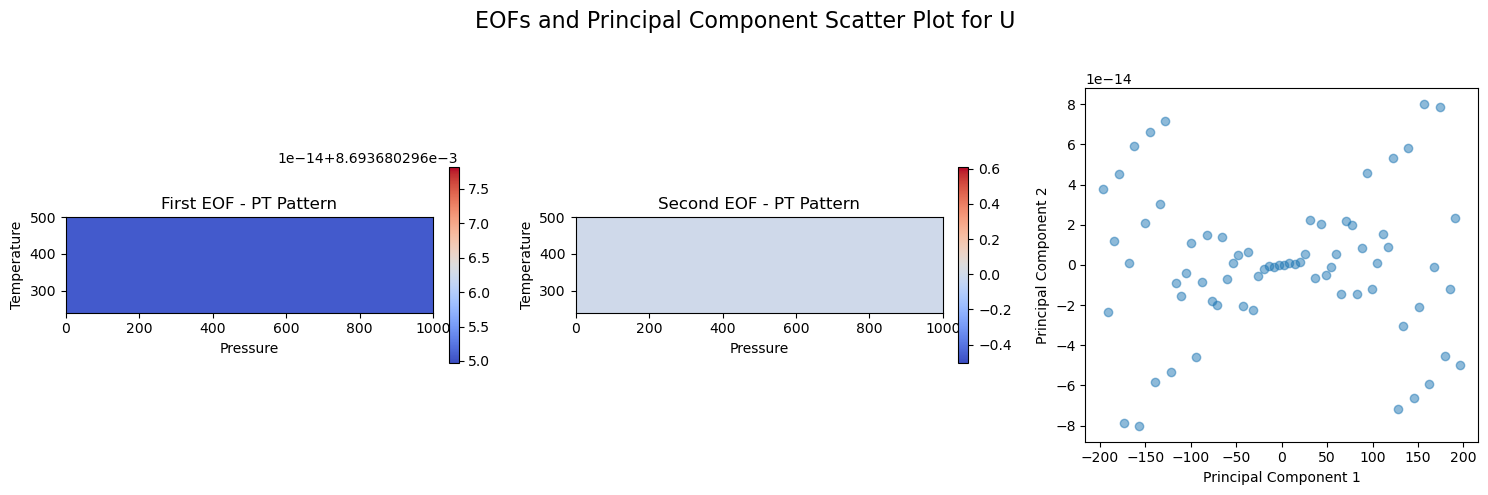

Explained Variance Ratios: [1.00000000e+00 9.24365213e-32]


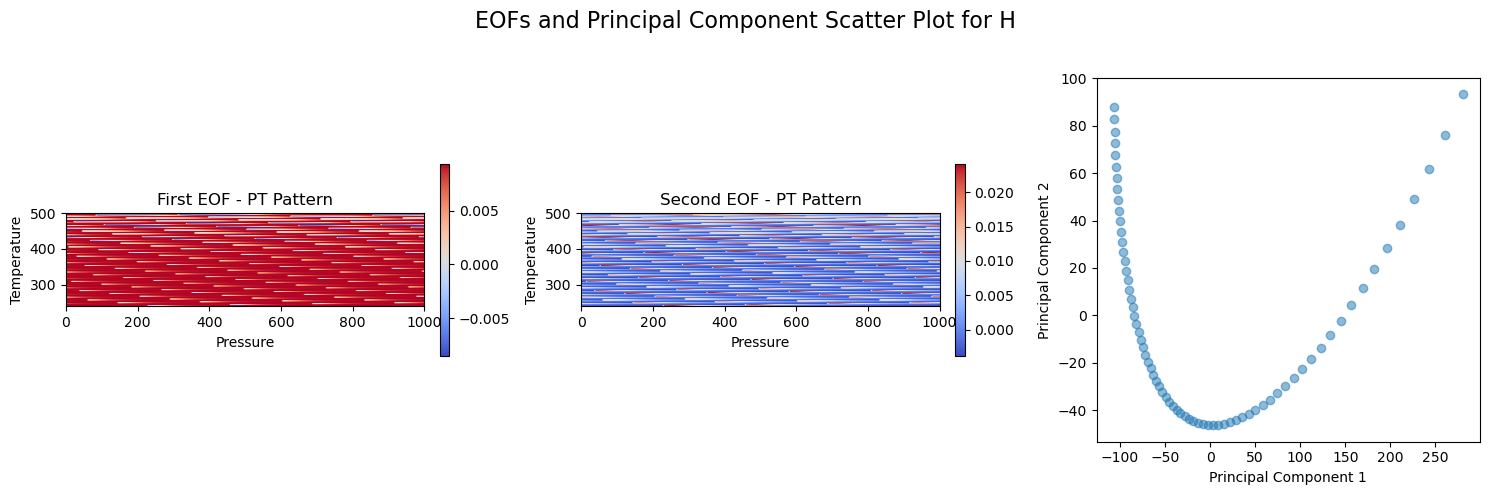

Explained Variance Ratios: [0.86984572 0.1300621 ]


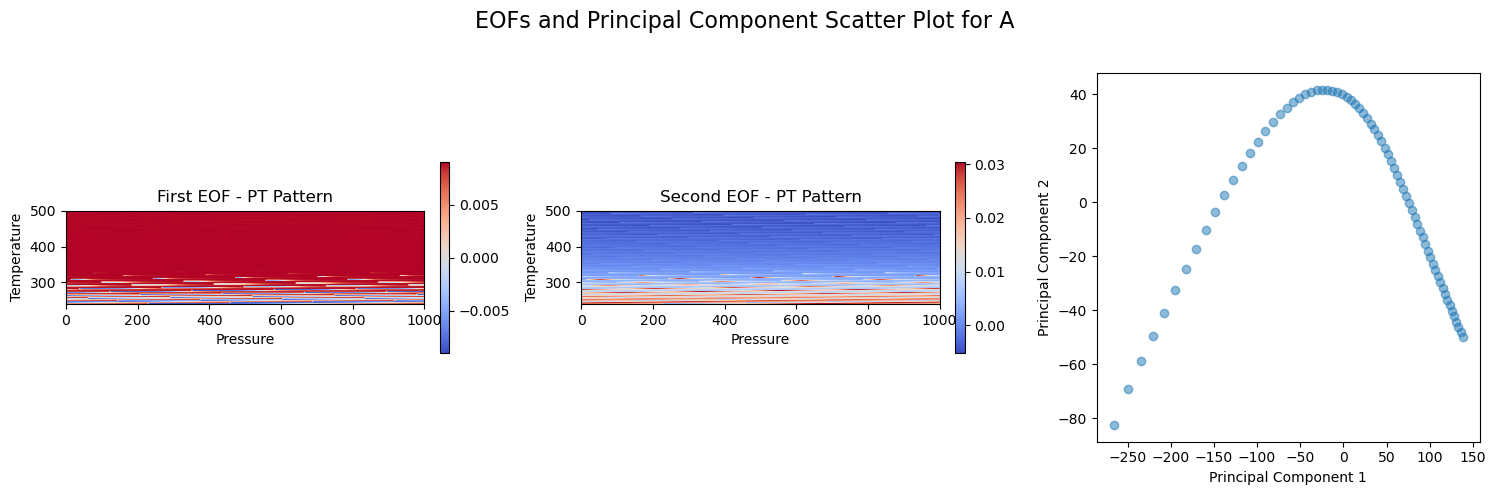

Explained Variance Ratios: [0.9179008  0.08125075]


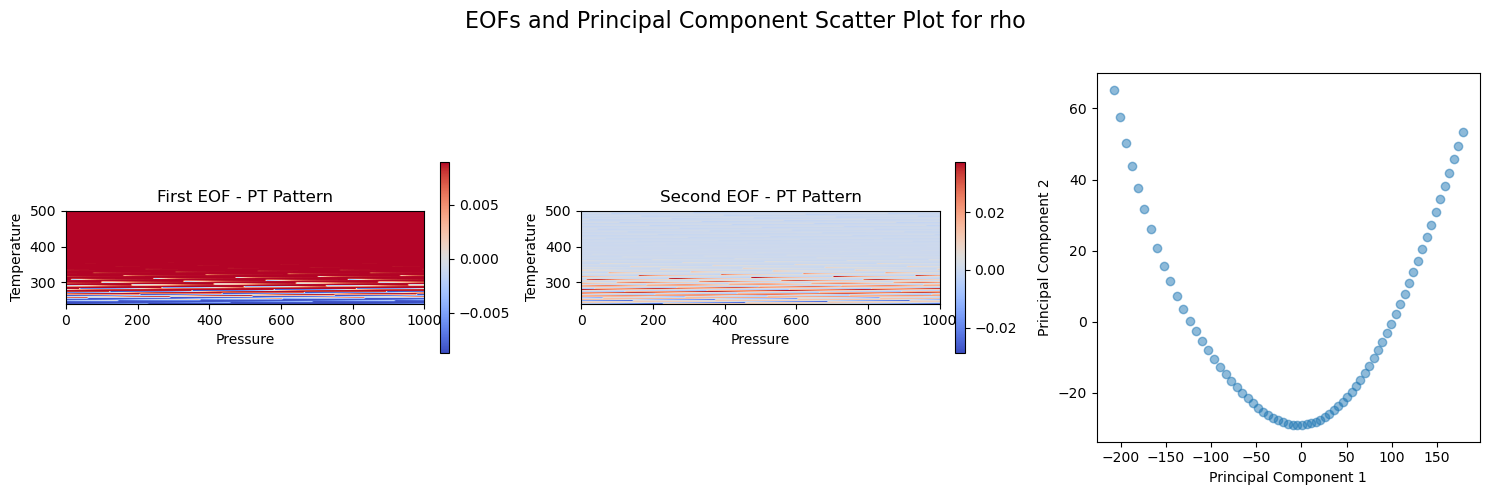

Explained Variance Ratios: [0.9274167  0.05348599]


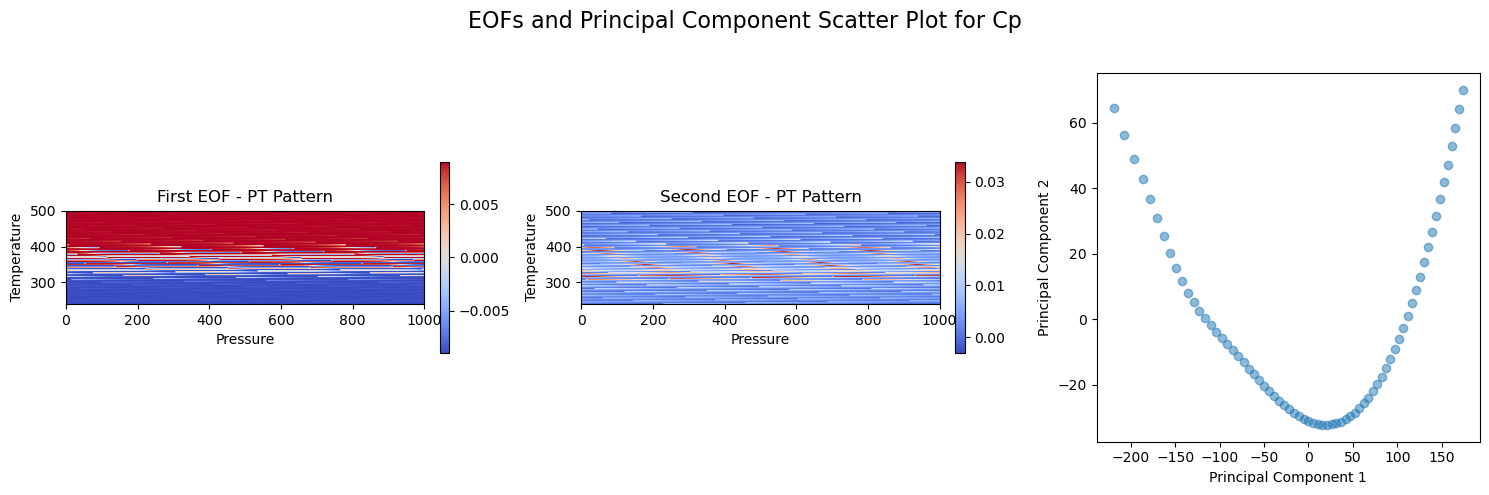

Explained Variance Ratios: [0.93217087 0.06540466]


In [3]:
# read parquet file with all data
data_j = pd.read_parquet('NaCl_combined_lists.parquet')
data_j.head()

data = data_j.to_numpy()
P = data_j['P_Mpa']
T = data_j['T_K']
M = data_j['m_molkg']

# standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)

c1 = data_j['m_molkg'] 
all_C = c1.tolist()


props = ('G', 'S', 'U', 'H', 'A', 'rho', 'Cp') #, 'Kt', 'Kp', 'Ks', 'alpha', 'vel', 'mus', 'muw', 'Vm', 'Cpm', 'Cpa', 'Va', 'Vex', 'phi', 'aw', 'gam', 'Gex')

for j in props: 

    tdv = data_j[f'{j}']

    data_3d = data[:,[props.index(f'{j}')]].reshape(len(np.unique(P)), len(np.unique(T)), len(np.unique(M)))
    data_reshaped = data_3d.reshape(len(np.unique(M)), len(np.unique(T)) * len(np.unique(P)))

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data_reshaped)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_standardized) 
    eofs = pca.components_.reshape(2, len(P.unique()), len(T.unique()))
 
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first EOF (Spatial Pattern)
    im0 = axs[0].imshow(eofs[0], extent=[0, 1000, 240, 500], cmap='coolwarm')
    axs[0].set_title('First EOF - PT Pattern')
    axs[0].set_xlabel('Pressure')
    axs[0].set_ylabel('Temperature')
    fig.colorbar(im0, ax=axs[0], fraction=0.025, pad=0.04)

    # Plot the second EOF (Spatial Pattern)
    im1 = axs[1].imshow(eofs[1], extent=[0, 1000, 240, 500], cmap='coolwarm')
    axs[1].set_title('Second EOF - PT Pattern')
    axs[1].set_xlabel('Pressure')
    axs[1].set_ylabel('Temperature')
    fig.colorbar(im1, ax=axs[1], fraction=0.025, pad=0.04)

   # Plot scatter plot 
    axs[2].scatter(principal_components[:, 0], principal_components[:, 1], alpha = 0.5)
    axs[2].set_xlabel('Principal Component 1')
    axs[2].set_ylabel('Principal Component 2')

    # Set the figure title
    fig.suptitle(f'EOFs and Principal Component Scatter Plot for {j}', fontsize=16)

    # Adjust layout to prevent overlap
    plt.subplots_adjust(wspace=0.4)  # Increase the width space between subplots

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make room for the suptitle
    plt.show()

    # Explained variance ratios
    explained_variance = pca.explained_variance_ratio_
    print("Explained Variance Ratios:", explained_variance)

I first reshape the lists back into the original 3D array for each variable ('G', 'S', 'U', 'H', 'A', 'rho', 'Cp') with dimensions corresponding to unique values of P, T, and M (data_3d). Then, this array is again reshaped into a 2D array where rows correspond to unique values of M and columns correspond to the combination of P and T; this is then standardized using sklearn's StandardScaler.

I use PCA to reduce this data to 2 principle components, where the eofs are the principal components reshaped back into the original 3D dimension (they have shape 2xPxT). The primary and secondary modes of variability are shown over PT space in the spatial pattern plots, and the scatter plots show the relationship (if any) between the first and second principal components in the reduced 2D space.

Apparently there are no trends in the gibbs energy or entropy data, which I find odd; I'll need to look into that more, and possibly change the standardization method. For A, rho, H, and Cp, the scatter plots indicate a quadratic relationship between PC1 and PC2. 2 groups are apparent for internal energy (U). For all variables, PC1 captures most of the variance, as indicated by the Explained Variance Ratios.




/opt/anaconda3/envs/mlgeo-dataset/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


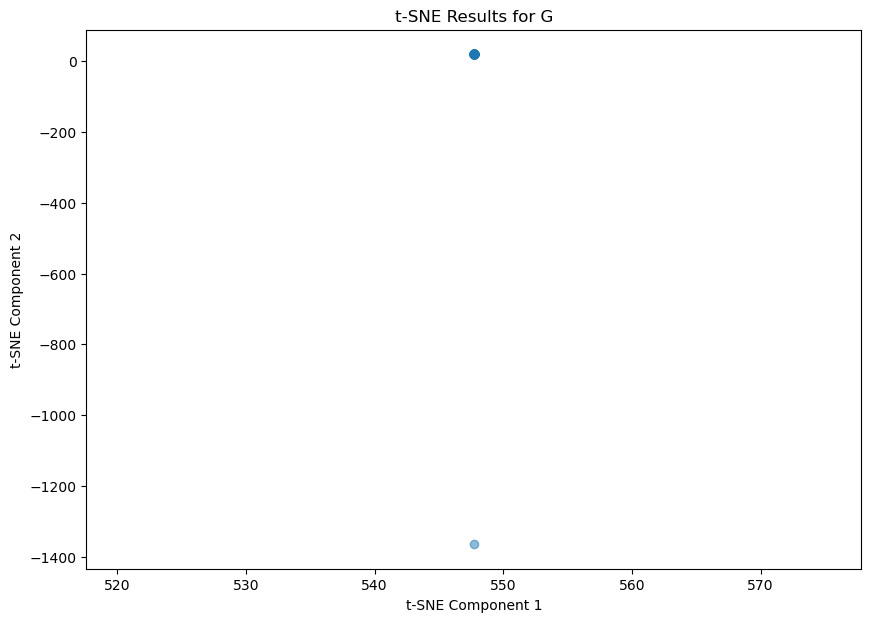

: 

In [4]:
### attempt to apply t-Distributed Stochastic Neighbor Embedding (t-SNE) to the data

props = ('G', 'S', 'U') #, 'H', 'A', 'rho', 'Cp') #, 'Kt', 'Kp', 'Ks', 'alpha', 'vel', 'mus', 'muw', 'Vm', 'Cpm', 'Cpa', 'Va', 'Vex', 'phi', 'aw', 'gam', 'Gex')

for j in props: 

    tdv = data_j[f'{j}']

    data_3d = data[:,[props.index(f'{j}')]].reshape(len(np.unique(P)), len(np.unique(T)), len(np.unique(M)))
    data_reshaped = data_3d.reshape(len(np.unique(M)), len(np.unique(T)) * len(np.unique(P)))

    # Initialize t-SNE  
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

    # Fit and transform data
    tsne_results = tsne.fit_transform(data_reshaped)

    # Plot results
    plt.figure(figsize=(10, 7))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.title(f't-SNE Results for {j}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()